In [3]:
import pandas as pd

from preprocess import clean_dataframe,split_stratify
# https://scikit-learn.org/stable/modules/svm.html
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

raw_data = pd.read_csv('Murder_Data.zip', index_col=0, compression='zip')
cleaned_data = clean_dataframe(raw_data)
#get a stratisfied subset to test the algorithms on
#train,test = split_stratify(...)
cleaned_data, _ = split_stratify(cleaned_data,['OffSex', 'OffRace', 'OffEthnic'],0.20,0.01)
cleaned_data.shape

C:\Users\PedroAntonio\Anaconda3\envs\ACML\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(114088, 28)

In [4]:
input_features = ['County', 'State', 'Area', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'VicCount', 'Weapon', 'Subcircum', 'Circumstance', 'Homicide']
output_features = ['OffAge', 'OffSex', 'OffRace', 'OffEthnic', 'OffCount']

X = cleaned_data[input_features]
Y = cleaned_data[output_features]

X['VicAge'].replace(to_replace='Unknown', value = -1, inplace = True)
Y['OffAge'].replace(to_replace='Unknown', value = -1, inplace = True)

X = pd.get_dummies(X,columns=['County', 'State', 'Area', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon', 'Subcircum', 'Circumstance', 'Homicide'])

x_train, x_rest, y_train, y_rest = train_test_split(X, Y, test_size=0.20, random_state=20)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.50, random_state=20)

C:\Users\PedroAntonio\Anaconda3\envs\ACML\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


0.8894732228942064


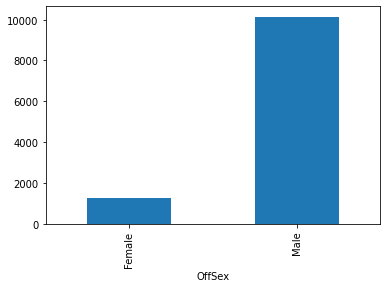

In [5]:
df=y_test.groupby(["OffSex"]).size()
df.plot(kind='bar')
print(len(y_test[y_test["OffSex"]=="Male"])/len(y_test))

no weighted penalty for the classes
done fitting
0.8885090717854326
Accuracy on female class: 0.010309278350515464
Accuracy on male class: 0.9976350019708317
(array([0.35135135, 0.89025677]), array([0.01030928, 0.997635  ]), array([0.02003082, 0.94089219]), array([ 1261, 10148], dtype=int64))


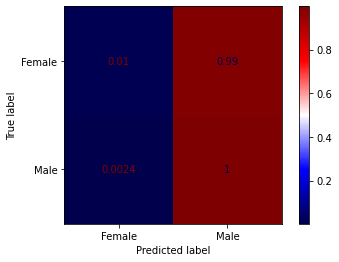

In [6]:
#clf = svm.LinearSVC(class_weight={'Female':10, 'Male': 1},dual=False)
print("no weighted penalty for the classes")
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train["OffSex"])
print("done fitting")
print(clf.score(x_test,y_test["OffSex"]))
print("Accuracy on female class: "+str(clf.score(x_test[y_test["OffSex"]=="Female"],y_test["OffSex"][y_test["OffSex"]=="Female"])))
print("Accuracy on male class: "+str(clf.score(x_test[y_test["OffSex"]=="Male"],y_test["OffSex"][y_test["OffSex"]=="Male"])))
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffSex"],normalize='true',cmap="seismic")
print(precision_recall_fscore_support(y_test["OffSex"],clf.predict(x_test)))

In [13]:
import random
#TODO:  -Maybe adding k-point crossover would improve the search?
#        as it would look at different parts of the search space, especially for higher number oof classes i think
#       -get rid of hardcoded values(n_new for example)
#       -Maybe do tests with gridsearch?
#       -Maybe random search is better/faster (test 50 random weights for example)
#       -improve the evaluation func? (70,70 vs 50,100)
#        could try out min (1-acc1/acc2) to force acc1 and acc2 to be as similar as possible to each other
#        maybe combine with the current acc1*acc2 to both maximise them and make them similar.
#        still unsure how this new proposed eval func would work for multiclass (would need to know the proportions between all classes and not just 2)
#       -keep track of all searched (w1,w2,fitness) and see if these can be plotted to check the shape of the
#        search space
#       -possibly interesting/related papers:
#        http://www.ijfcc.org/vol8/541-CE026.pdf
#        https://www.jncet.org/Manuscripts/Volume-9/Issue-11/Vol-9-issue-11-M-02.pdf
def genetic_weight_search(n_pop,n_iter,tree,classes,x_train,y_train,x_val,y_val):
    pop = init_population(n_pop,classes)
    for i in range(n_iter):
        fitness = eval_pop(pop,tree,x_train,y_train,x_val,y_val)
        sorted_pop = sorted(zip(fitness,pop), key = lambda l: l[0],reverse=True)
        print(f"best weights in generation {i}: {sorted_pop[0]}")
        parents = select_parents(sorted_pop)
        #no crossover
        children = generate_new_pop(parents,n_new=10)
        pop = parents+children+init_population(5,classes)
    print("best found:"+str(pop[0]))
    return pop[0]


def init_population(n_pop,classes):
    pop = []
    for i in range(n_pop):
        individual = {}
        for cls in classes:
            individual[cls]=random.uniform(1,10)
        pop.append(individual)
    return pop

def eval_pop(pop,tree,x_train,y_train,x_val,y_val):
    fitness = []
    for individual in pop:
        clf = tree(class_weight=individual,dual=False)
        clf.fit(x_train, y_train)
        mean = 0
        multi = 1
        for cls in individual.keys():
            #it's possible some class is nit inside the val set with the current split
            try:
                score=clf.score(x_val[y_val==cls],y_val[y_val==cls])
                mean+=score
                multi*=score
            except:
                pass
        #todo: the current fitness value should be retought, for exaple: should 0.7/0.7 be considerd better as 0.5/1.0 or not?
        fitness.append(multi)
    return fitness

def select_parents(sorted_pop):
    res = [[ i for i, j in sorted_pop ],[ j for i, j in sorted_pop ]]
    pop = res[1]
    #return best 5 and 5 random as parents of the population
    parents = pop[:5]
    parents += random.sample(pop[5:], 5)
    return parents

def generate_new_pop(parents,n_new):
    new_pop = []
    for i in range(n_new):
        parent = random.sample(parents,1)[0]
        parent = parent.copy()
        child = {}
        for cls in parent.keys():
            child[cls]=parent[cls]+random.uniform(-0.4,0.4)
        new_pop.append(child)
    return new_pop

best weights in generation 0: (0.37683746853095074, {'Female': 8.349894648241575, 'Male': 1.5031021949391778})
best weights in generation 1: (0.41554293365583966, {'Female': 5.792248117795457, 'Male': 0.8953073807797737})
best weights in generation 2: (0.41554293365583966, {'Female': 5.792248117795457, 'Male': 0.8953073807797737})
best weights in generation 3: (0.42254981056866425, {'Female': 8.487573872828602, 'Male': 1.2421440631650678})
best weights in generation 4: (0.42702574291637874, {'Female': 5.594511818424748, 'Male': 0.7007665499921646})
best weights in generation 5: (0.43295395646164475, {'Female': 8.130913687801895, 'Male': 1.1023067528319164})
best weights in generation 6: (0.43295395646164475, {'Female': 8.130913687801895, 'Male': 1.1023067528319164})
best weights in generation 7: (0.4333189357290947, {'Female': 8.646408893066862, 'Male': 1.1391028178492952})
best weights in generation 8: (0.43366710065159436, {'Female': 7.99524741679939, 'Male': 1.03935169755206})
best 

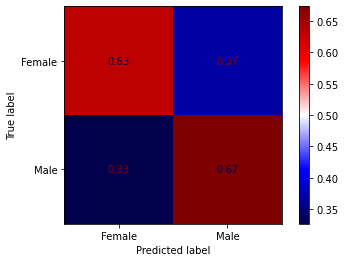

In [8]:
#clf = svm.LinearSVC(class_weight={'Female':10, 'Male': 1},dual=False)
best_found_weights = genetic_weight_search(30,20,svm.LinearSVC,list(cleaned_data['OffSex'].unique()),x_train,y_train["OffSex"],x_val,y_val["OffSex"])
clf = svm.LinearSVC(class_weight=best_found_weights,dual=False)
clf.fit(x_train, y_train["OffSex"])
print("done fitting")
print(clf.score(x_test,y_test["OffSex"]))
print("Accuracy on female class: "+str(clf.score(x_test[y_test["OffSex"]=="Female"],y_test["OffSex"][y_test["OffSex"]=="Female"])))
print("Accuracy on male class: "+str(clf.score(x_test[y_test["OffSex"]=="Male"],y_test["OffSex"][y_test["OffSex"]=="Male"])))
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffSex"],normalize='true',cmap="seismic")
print(precision_recall_fscore_support(y_test["OffSex"],clf.predict(x_test)))

<AxesSubplot:xlabel='OffRace'>

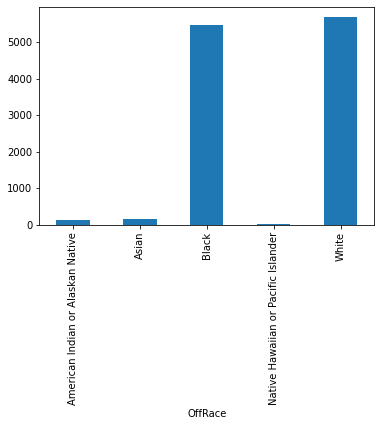

In [9]:
df=y_test.groupby(["OffRace"]).size()
df.plot(kind='bar')
#print(len(y_test[(y_test["OffRace"]=="Black") | (y_test["OffRace"]=="White") ])/len(y_test))

no weighted penalty for the classes
done fitting
0.8716802524322903
(array([0.66666667, 0.63432836, 0.91844543, 0.5       , 0.84252855]), array([0.48387097, 0.59859155, 0.83534799, 0.33333333, 0.9221831 ]), array([0.56074766, 0.61594203, 0.87492806, 0.4       , 0.88055812]), array([ 124,  142, 5460,    3, 5680], dtype=int64))


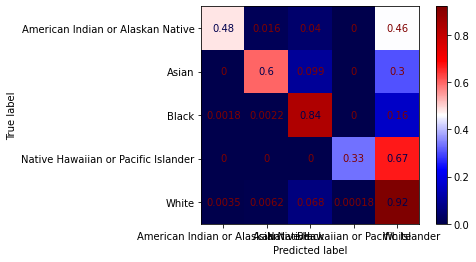

In [10]:
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train["OffRace"])
print("no weighted penalty for the classes")
print("done fitting")
print(clf.score(x_test,y_test["OffRace"]))
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffRace"],normalize='true',cmap="seismic")
print(precision_recall_fscore_support(y_test["OffRace"],clf.predict(x_test)))

In [16]:
best_found_weights = genetic_weight_search(30,20,svm.LinearSVC,list(cleaned_data['OffRace'].unique()),x_train,y_train["OffRace"],x_val,y_val["OffRace"])

best weights in generation 0: (0.29784662155042013, {'American Indian or Alaskan Native': 7.607030006410539, 'Asian': 1.762497387092303, 'Black': 1.7215103092203379, 'White': 1.3138917690028242, 'Native Hawaiian or Pacific Islander': 3.906067263607059})
best weights in generation 1: (0.29784662155042013, {'American Indian or Alaskan Native': 7.607030006410539, 'Asian': 1.762497387092303, 'Black': 1.7215103092203379, 'White': 1.3138917690028242, 'Native Hawaiian or Pacific Islander': 3.906067263607059})
best weights in generation 2: (0.3062025214576766, {'American Indian or Alaskan Native': 7.989858438768093, 'Asian': 3.632146019016535, 'Black': 3.679261760920033, 'White': 0.9740415028455337, 'Native Hawaiian or Pacific Islander': 5.5399197409978855})
best weights in generation 3: (0.3062025214576766, {'American Indian or Alaskan Native': 7.989858438768093, 'Asian': 3.632146019016535, 'Black': 3.679261760920033, 'White': 0.9740415028455337, 'Native Hawaiian or Pacific Islander': 5.53991

done fitting
(array([0.6036036 , 0.56329114, 0.87896571, 0.5       , 0.87352682]), array([0.54032258, 0.62676056, 0.87783883, 0.33333333, 0.87429577]), array([0.57021277, 0.59333333, 0.87840191, 0.4       , 0.87391113]), array([ 124,  142, 5460,    3, 5680], dtype=int64))


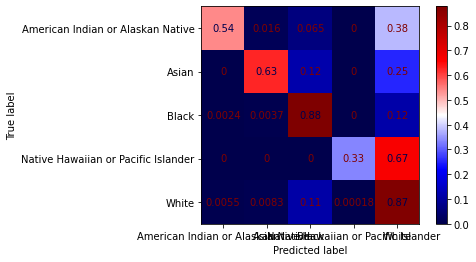

In [17]:
clf = svm.LinearSVC(class_weight=best_found_weights,dual=False)
clf.fit(x_train, y_train["OffRace"])
print("done fitting")
clf.score(x_test,y_test["OffRace"])
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffRace"],normalize='true',cmap="seismic")
print(precision_recall_fscore_support(y_test["OffRace"],clf.predict(x_test)))